# Cell type assignment

In this notebook, we analyse the cell type predictions of the automated annotation model and validate its cell type assignments using marker gene expression and other sources of information (e.g. knowledge of developmental stages and anatomical dissections).  

In [32]:
from scrabbit.annotate import *
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import math

seed = 0
sc.set_figure_params(dpi=150,dpi_save=300)


### Load data

In [14]:
# Load data
r_data = sc.read_h5ad("../data-in/cell_type_annotation/rabbit_corrected_clustered.h5ad")
orthologs = pd.read_csv("../data-in/orthologs/rabbit_mouse_orthologs.tsv", sep="\t")


In [15]:
# TODO make gene names default var.index for r_data
r_genes = pd.read_csv("../data-in/raw/genes.tsv", sep="\t")
r_data.var.index = r_genes["gene_name"]


In [16]:
# TODO add this as default for r_data
#r_data.obs["anatomical_loc"] = r_data.obs["anatomical_loc"].astype("str")
r_data.obs["anatomical_loc"] = ""

# Add anatomical location info
r_data.obs["anatomical_loc"][r_data.obs["sample"].isin([12,16])] = "Head"
r_data.obs["anatomical_loc"][r_data.obs["sample"].isin([13,17])] = "Trunk"
r_data.obs["anatomical_loc"][r_data.obs["sample"].isin([14,18])] = "Tail"
r_data.obs["anatomical_loc"][r_data.obs["sample"].isin([15,19,22,26])] = "Yolk sac"
r_data.obs["anatomical_loc"][~r_data.obs["sample"].isin([12,16,13,17,14,18,15,19,22,26])] = "Whole embryo"
r_data.obs["anatomical_loc"] = r_data.obs["anatomical_loc"].astype("category")
r_data.obs["anatomical_loc"] = r_data.obs["anatomical_loc"].cat.reorder_categories(["Head", "Trunk", 
                                                                                    "Tail","Yolk sac",
                                                                                    "Whole embryo"])

anatomy_colours = {
    "Head":"red",
    "Trunk": "blue",
    "Tail": "green",
    "Yolk sac": "orange",
    "Whole embryo": "grey"
}
r_data.uns["anatomical_loc_colors"] = [anatomy_colours[x] for x in r_data.obs["anatomical_loc"].cat.categories]

<ipython-input-16-7006d37b7cb8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_data.obs["anatomical_loc"][r_data.obs["sample"].isin([12,16])] = "Head"
<ipython-input-16-7006d37b7cb8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_data.obs["anatomical_loc"][r_data.obs["sample"].isin([13,17])] = "Trunk"
<ipython-input-16-7006d37b7cb8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_data.obs["anatomical_loc"][r_data.obs["sample

In [17]:
m_markers = pd.read_csv("../data-in/cell_type_annotation/celltype_markers.tsv", sep="\t")
m_markers = {i: m_markers[i].dropna().to_list() for i in m_markers.columns}


In [18]:
orthologs_copy = orthologs
orthologs_copy.index = orthologs_copy["mouse_gene_name"]
r_markers = {i: list(orthologs_copy.loc[[x for x in m_markers[i] if x in orthologs_copy["mouse_gene_name"]] ,"rabbit_gene_name"]) for i in list(m_markers.keys())  }


### Cluster data

Cell type labels are assigned to clusters identified in the high-dimensional gene expression space. Here we perfrom Leiden clustering at various resolutions to identify both coarse and fine-grained populations of cells.

For the sake of brevity, here we have used precomputed clusterings. See `scripts/cluster.py` to run the full clustering.  

In [ ]:
# Load clusters from file
clusters = pd.read_csv("../data-in/cell_type_annotation/clusters.tsv",sep="\t")
r_data.obs = r_data.obs.join(clusters)


### Divide dataset

To simplify the annotation process, the dataset is initially divded into broad regions to be annotated separately. 

In [19]:
r_blood = r_data[r_data.obs["leiden_res1"].isin(['4','19','20','8']),]
r_meso = r_data[r_data.obs["leiden_res1"].isin(['17','2','12','22']),]
r_neural = r_data[r_data.obs["leiden_res1"].isin(['3','7']),]
r_misc = r_data[r_data.obs["leiden_res1"].isin(['6','23','21','18']),]
r_exeEcto = r_data[r_data.obs["leiden_res1"].isin(['9','0','16']),]
r_exeMeso = r_data[r_data.obs["leiden_res1"].isin(['5','14','10','1','22']),]
r_exeEndo = r_data[r_data.obs["leiden_res1"].isin(['13','15','11']),]



### Useful plots

For each broad region, we plot the automated annotation predictions, along with clusterings of different resolutions. These results are compared to UMAP plots of marker gene expression and are cross-validated with other sources of information such as the developmental stage and anatomical dissection.


<AxesSubplot:title={'center':'anatomical_loc'}, xlabel='UMAP1', ylabel='UMAP2'>

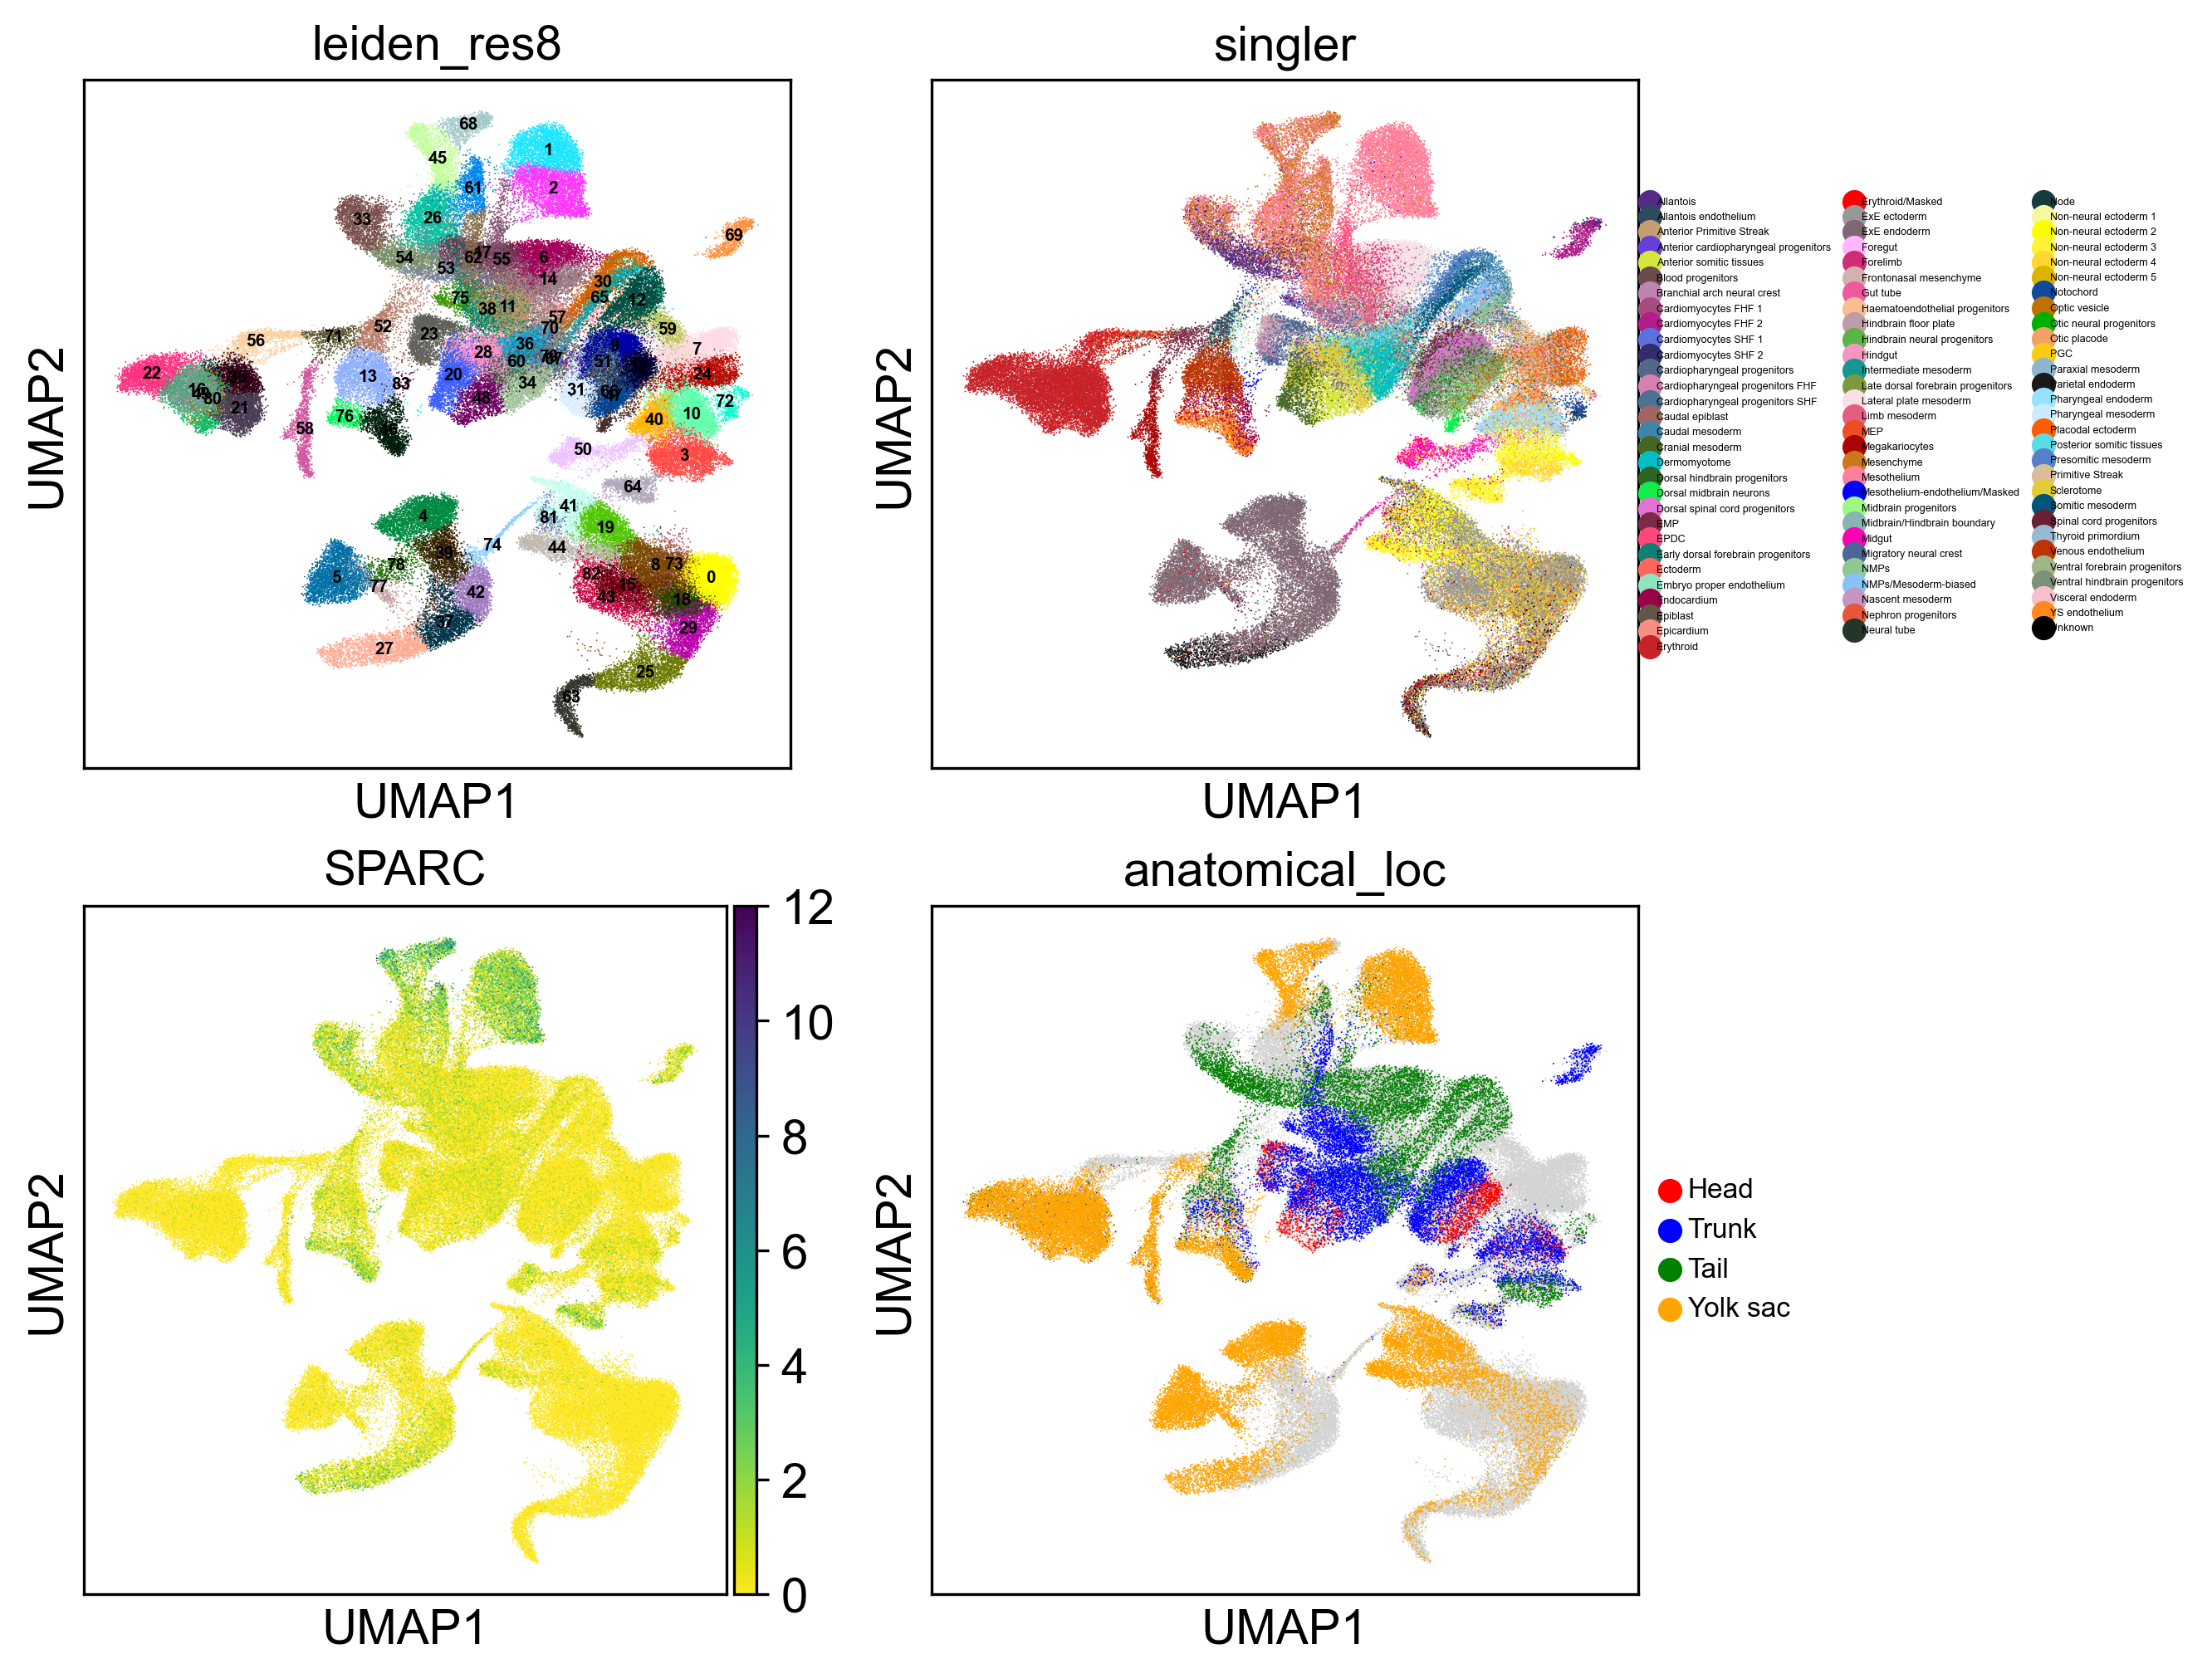

In [229]:
fig, axs = plt.subplots(2, 2,figsize=(8,8))

sc.pl.umap(r_data,color=["leiden_res8"],legend_loc="on data",legend_fontsize=5,ax=axs[0,0],show=False)
sc.pl.umap(r_data,color=["singler"],legend_fontsize=3,ax=axs[0,1],show=False)
sc.pl.umap(r_data,color=r_markers["Yolk sac endothelium"][1],color_map="viridis_r",ax=axs[1,0],show=False)
sc.pl.umap(r_data,color=["anatomical_loc"],groups=["Head","Trunk","Tail","Yolk sac"],legend_fontsize=8,ax=axs[1,1],show=False)


#frac_plot = plotObsFraction(r_data,"")

It's also informative to plot the frequency distribution of cell type predictions within each cluster. Since the annotation model makes predictions independently for each cell, if there are clusters of cells with a common cell type prediction, it may be suggestive of a reliable annotation. Similarly, we can plot the distribution across clusters for each predicted cell type label. 

<AxesSubplot:title={'center':'singler: YS endothelium (1463 cells)'}, xlabel='Fraction of cells', ylabel='leiden_res8'>

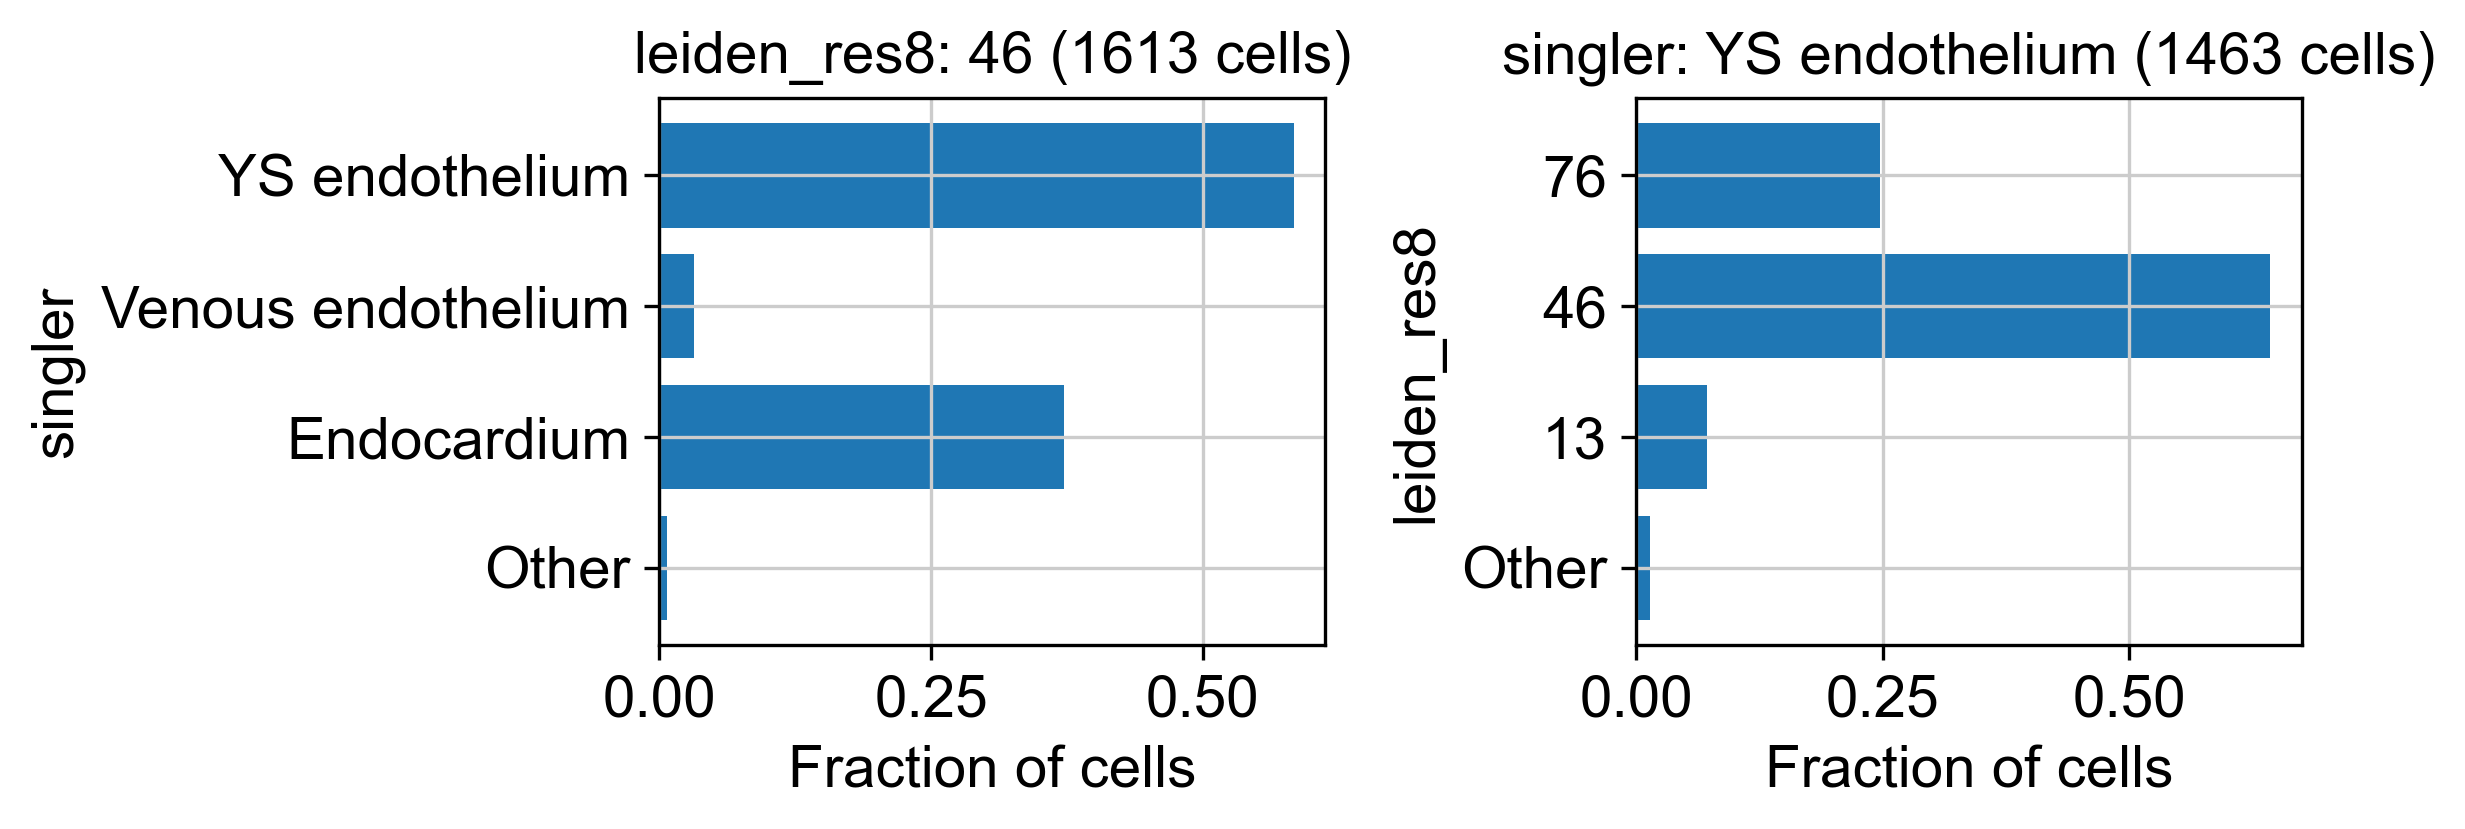

In [33]:
fig, axs = plt.subplots(1, 2,figsize=(8,3))

plotObsFraction(r_data,obA="46", obsA = "leiden_res8", obsB = "singler", 
                     obsA_ignore_thresh = 50 , obsB_ignore_thresh = 0.02,ax=axs[0])
                     #colours = scrabbit.getCelltypeColours())
    
plotObsFraction(r_data,obA="YS endothelium", obsA = "singler", obsB = "leiden_res8", 
                     obsA_ignore_thresh = 50 , obsB_ignore_thresh = 0.02,ax=axs[1])

### Make annotation plots 

We can produce the figures above for each broad region, and for each clustering.  First we do this looking at the whole dataset before then focussing in on each region. 

### Whole dataset

In [ ]:
Path("../figs/celltype_annotation/annotation_pipeline/whole_dataset/").mkdir(parents=True, exist_ok=True)
makeAnnotationPlots(r_data, 
                    clusters = ["leiden_res8"],
                    model_predictions = "singler",
                   markers = r_markers,
                    other_obs = ["stage","anatomical_dissection"],
                   export_dir = "../figs/celltype_annotation/annotation_pipeline/whole_dataset/")

## Mesoderm

In [35]:
# Compute subset specific clustering
sc.tl.leiden(r_meso, resolution=2, key_added="mesoderm_leiden_res2", random_state = seed)
sc.tl.leiden(r_meso, resolution=5, key_added="mesoderm_leiden_res5", random_state = seed)

C:\anaconda\envs\rabbit-gastrulation-python\lib\site-packages\scanpy\tools\_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


<AxesSubplot:title={'center':'mesoderm_leiden_res5'}, xlabel='UMAP1', ylabel='UMAP2'>

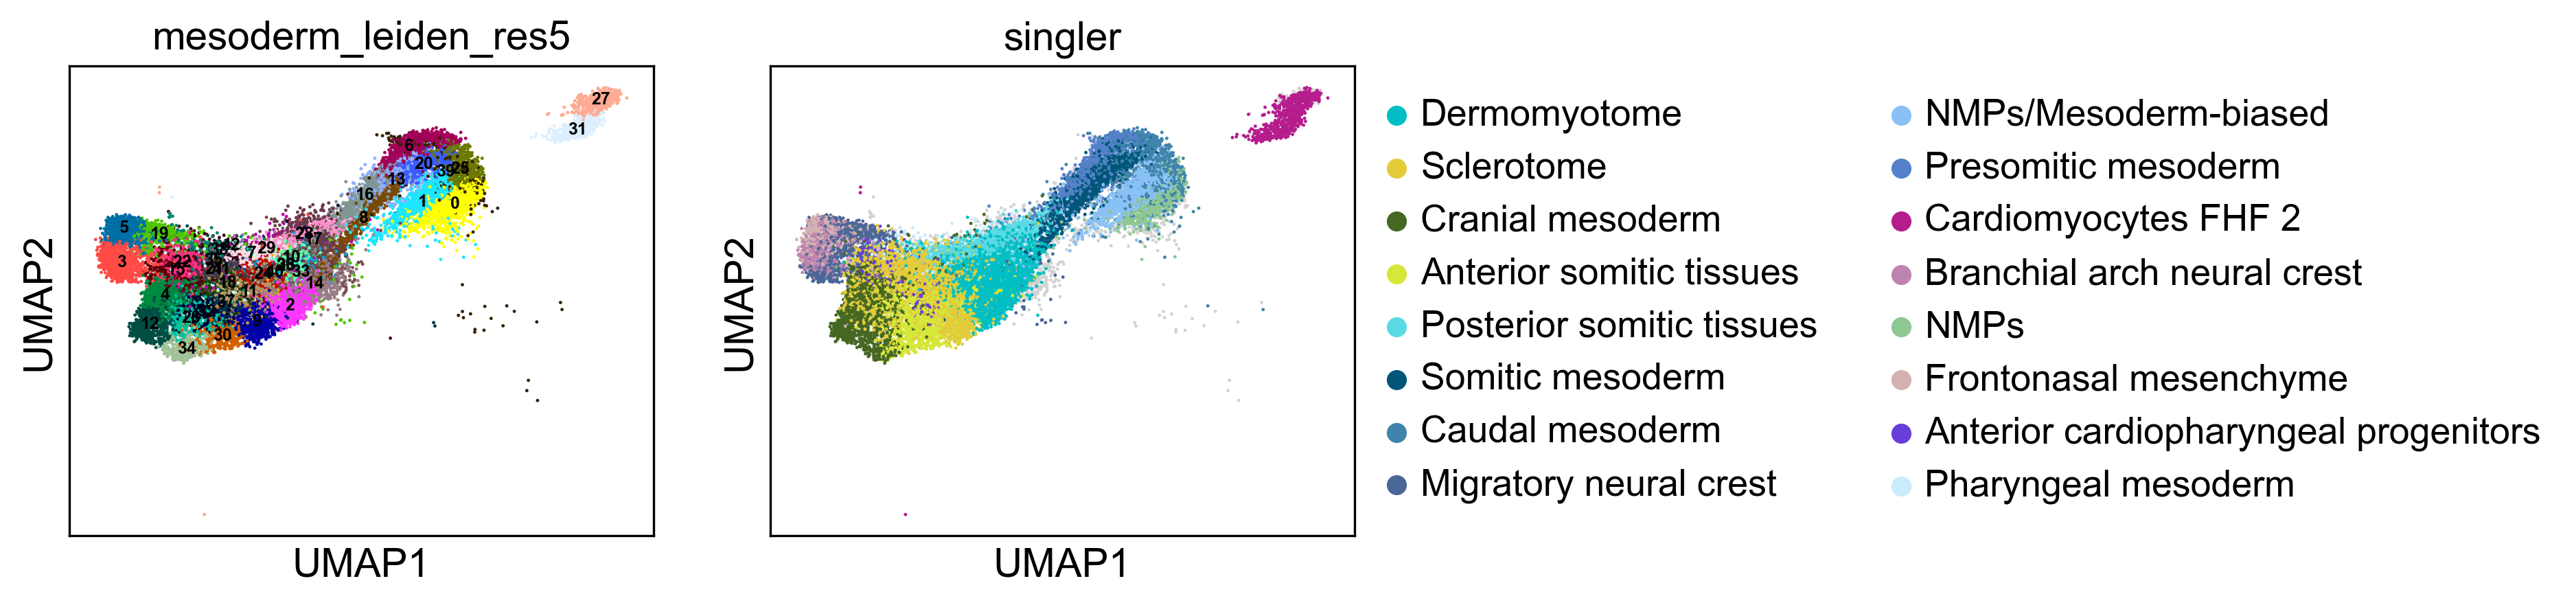

In [37]:
fig, axs = plt.subplots(1, 2,figsize=(8,3))


sc.pl.umap(r_meso, color = "singler", groups=filterMostCommonObs(r_meso,"singler",0.01), 
            ax=axs[1], show=False)

sc.pl.umap(r_meso, color = "mesoderm_leiden_res5",
           legend_loc="on data", legend_fontsize=6, ax=axs[0], show=False)


### Run plotting pipeline

In [372]:
# Create directory for mesoderm region
Path("../figs/celltype_annotation/annotation_pipeline/r_meso/").mkdir(parents=True, exist_ok=True)

# Filter out cell types unlikely to be in mesodermal region
mesoderm_celltypes = ["Anterior cardiopharyngeal progenitors","Anterior somitic tissues","Branchial arch neural crest",
                     "Cardiomyocytes FHF 1", "Cardiomyocytes FHF 2", "Cardiomyocytes SHF 1","Cardiomyocytes SHF 2",
                     "Cardiopharyngeal progenitors", 'Cardiopharyngeal progenitors SHF','Cranial mesoderm',
                     "Dermomyotome","ExE mesoderm","Frontonasal mesenchyme","Kidney",'Lateral plate mesoderm','Limb mesoderm',
                     "Migratory neural crest","Myocardium",'Nephron progenitors','Posterior somitic tissues','Sclerotome']


makeAnnotationPlots(r_meso, 
                    clusters = ["leiden_res8", "mesoderm_leiden_res2","mesoderm_leiden_res5"],
                    model_predictions = "singler",
                   markers = {k: r_markers[k] for k in mesoderm_celltypes},
                   export_dir = "../figs/celltype_annotation/annotation_pipeline/r_meso/")

### Assign cell types

By manually inspecting all of this information, we then determine the most-likely identity for each cluster. 

In [172]:
# Perform assignment
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res5", ["30","26","32","37"], "assigned_celltype", "Anterior somitic tissues")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res5", ["34","12","4"], "assigned_celltype", "Cranial mesoderm")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res5", ["9","11","18","21","35","38","22","41"], "assigned_celltype", "Sclerotome")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res5", ["24","40","2","33","14","10","23","36"], "assigned_celltype", "Dermomyotome")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res5", ["1"], "assigned_celltype", "NMPs/Mesoderm-biased")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res5", ["0"], "assigned_celltype", "NMPs")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res5", ["25","39"], "assigned_celltype", "Caudal mesoderm")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res5", ["7","28","29"], "assigned_celltype", "Posterior somitic tissues")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res5", ["20","8"], "assigned_celltype", "Somitic mesoderm")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res5", ["13","6","16"], "assigned_celltype", "Presomitic mesoderm")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res5", ["15"], "assigned_celltype", "Anterior cardiopharyngeal progenitors")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res5", ["27","31"], "assigned_celltype", "Cardiomyocytes FHF 2")
assignCelltypeAdataSubset(r_data, r_meso, "mesoderm_leiden_res5", ["17"], "assigned_celltype", "Nephron progenitors")

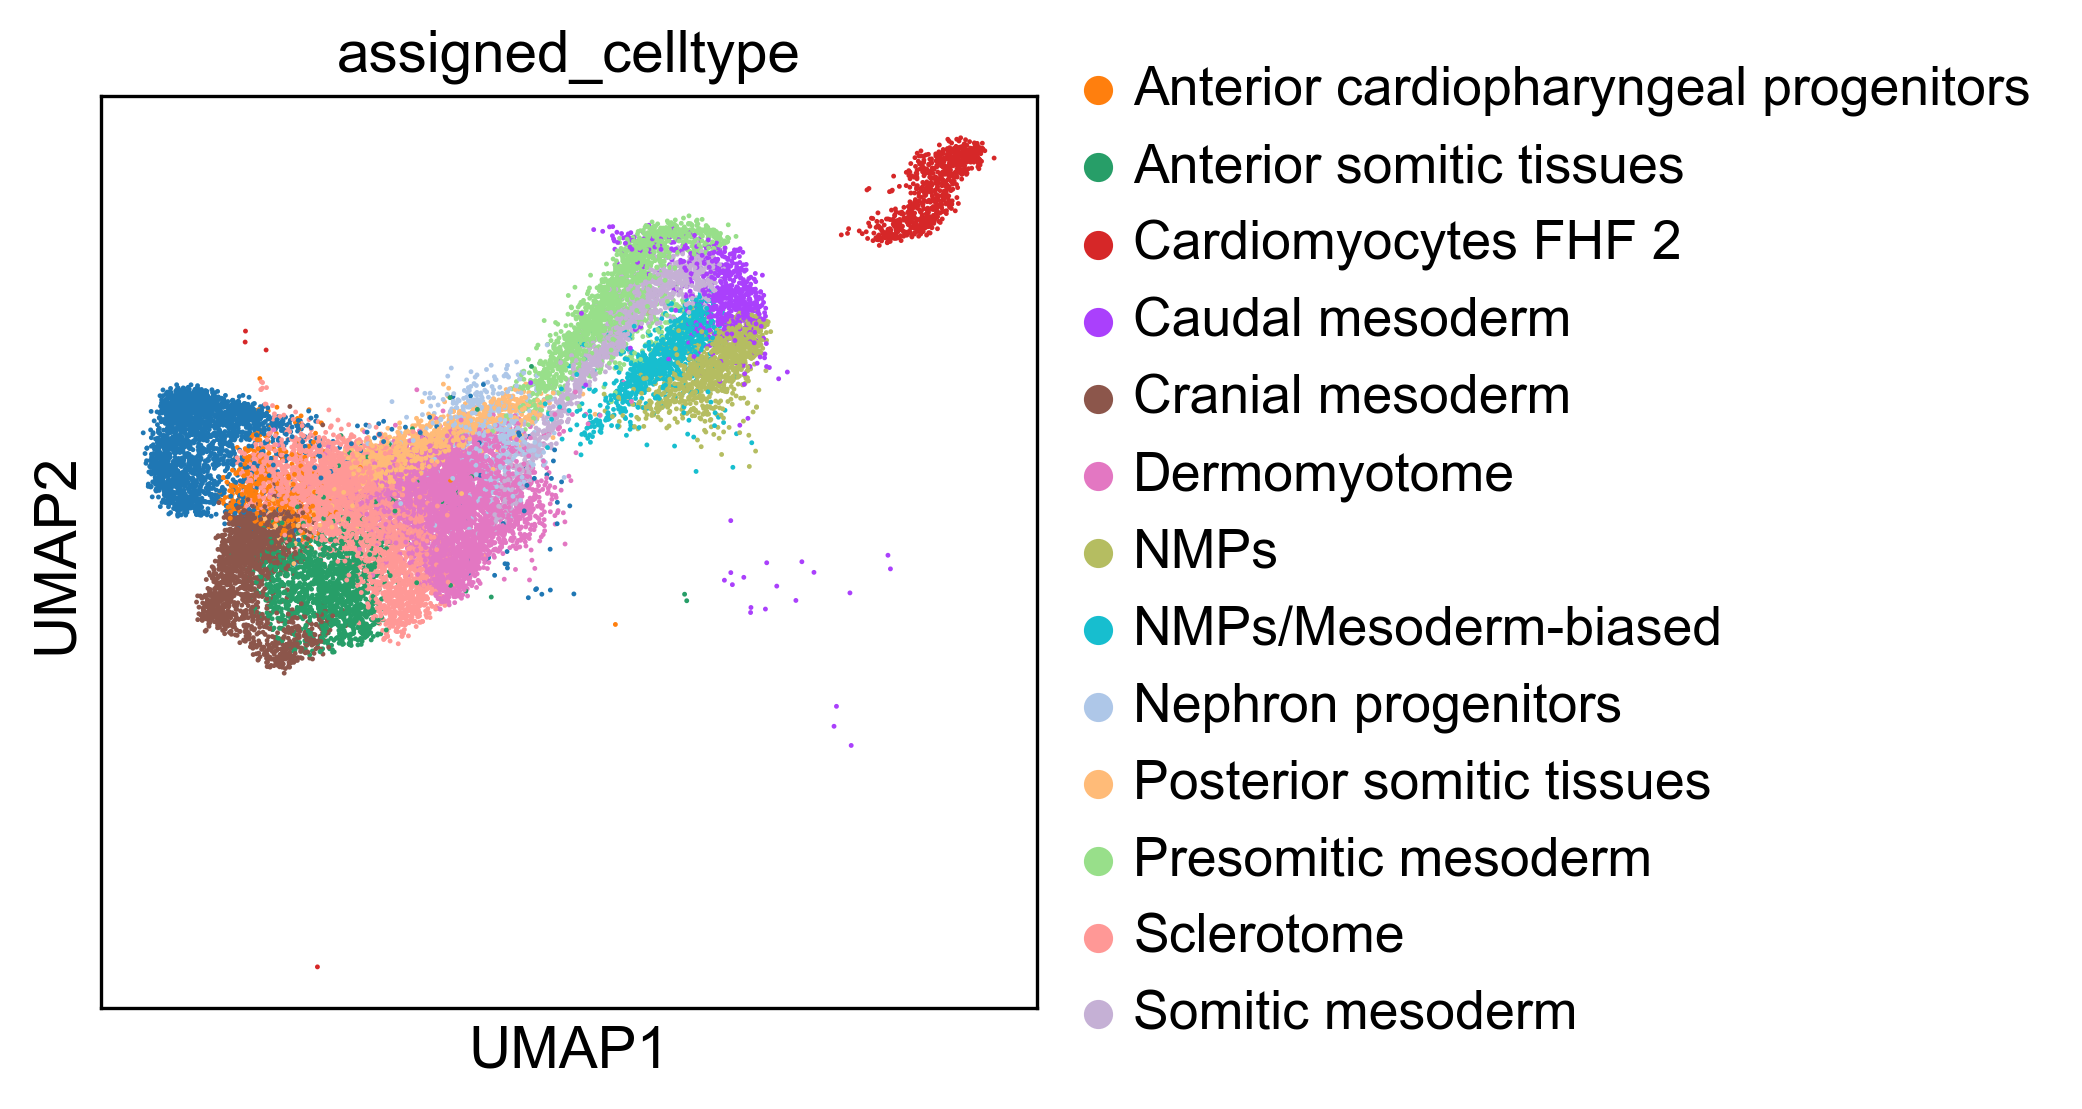

In [174]:
sc.pl.umap(r_meso, color = "assigned_celltype")